# Snorkel Workshop: Extracting Spouse Relations from the News

## Part 3: Training the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np

# Connect to the database backend and initalize a Snorkel session
from lib.init import *

We repeat our definition of the `Spouse` `Candidate` subclass, and load the test set:

In [2]:
from snorkel.models import candidate_subclass
Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

Load development set gold labels

In [3]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

Helper functions

In [4]:
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

# I. Labeling Functions

Add all your labeling functions (and their dependencies) from Notebook 2 here. These will be used to train our generative model.

In [5]:
spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    name_parts = s.split(' ')
    return name_parts[-1] if len(name_parts) > 1 else None    

def LF_husband_wife(c):
    return 1 if len(spouses.intersection(get_between_tokens(c))) > 0 else 0

def LF_husband_wife_left_window(c):
    if len(spouses.intersection(get_left_tokens(c[0], window=2))) > 0:
        return 1
    elif len(spouses.intersection(get_left_tokens(c[1], window=2))) > 0:
        return 1
    else:
        return 0
    
def LF_same_last_name(c):
    p1_last_name = last_name(c.person1.get_span())
    p2_last_name = last_name(c.person2.get_span())
    if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
        if c.person1.get_span() != c.person2.get_span():
            return 1
    return 0

def LF_no_spouse_in_sentence(c):
    return -1 if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else 0

def LF_and_married(c):
    return 1 if 'and' in get_between_tokens(c) and 'married' in get_right_tokens(c) else 0
    
def LF_familial_relationship(c):
    return -1 if len(family.intersection(get_between_tokens(c))) > 0 else 0

def LF_family_left_window(c):
    if len(family.intersection(get_left_tokens(c[0], window=2))) > 0:
        return -1
    elif len(family.intersection(get_left_tokens(c[1], window=2))) > 0:
        return -1
    else:
        return 0

def LF_other_relationship(c):
    return -1 if len(other.intersection(get_between_tokens(c))) > 0 else 0

In [6]:
import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# Read in known spouse pairs and save as set of tuples
with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
    known_spouses = set(
        tuple(strip_special(x).strip().split(',')) for x in f.readlines()
    )
# Last name pairs for known spouses
last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
def LF_distant_supervision(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    return 1 if (p1, p2) in known_spouses or (p2, p1) in known_spouses else 0

def LF_distant_supervision_last_names(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    p1n, p2n = last_name(p1), last_name(p2)
    return 1 if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else 0

Now we set up and run the hyperparameter search, training our model with different hyperparamters and picking the best model configuration to keep. We'll set the random seed to maintain reproducibility.

Note that we are fitting our model's parameters to the training set generated by our labeling functions, while we are picking hyperparamters with respect to score over the development set labels which we created by hand.

In [7]:
LFs = [
    LF_distant_supervision, LF_distant_supervision_last_names, 
    LF_husband_wife, LF_husband_wife_left_window, LF_same_last_name,
    LF_no_spouse_in_sentence, LF_and_married, LF_familial_relationship, 
    LF_family_left_window, LF_other_relationship
]

In [8]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

np.random.seed(1701)
%time L_train = labeler.apply(split=0, parallelism=4)
L_train.shape

Clearing existing...
Running UDF...
CPU times: user 19.9 s, sys: 4.39 s, total: 24.3 s
Wall time: 1min 15s


(22254, 10)

# III: Unifying supervision

## 1. Majority Vote
The most simple way to unify the output of all your LFs is by computed the _unweighted majority vote_. 

In [9]:
L_dev = labeler.apply_existing(split=1, parallelism=4)

Clearing existing...
Running UDF...


In [10]:
from lib.scoring import *

majority_vote_score(L_dev, L_gold_dev)

pos/neg    190:2621 6.8%/93.2%
precision  36.84
recall     55.26
f1         44.21


## 2. Generative Model
In data programming, we use a more sophisitcated model to unify our labeling functions. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a generative model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which we will then use to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

### b) Training the Model

In [11]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
%time gen_model.train(L_train, epochs=500, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-4)

Inferred cardinality: 2
CPU times: user 5min 15s, sys: 653 ms, total: 5min 16s
Wall time: 5min 16s


In [12]:
for lf,w in zip(LFs,gen_model.weights.lf_accuracy):
    print w, "\t", lf.__name__

0.0730182787579 	LF_distant_supervision
0.0726817448892 	LF_distant_supervision_last_names
0.116622594112 	LF_husband_wife
0.109420302634 	LF_husband_wife_left_window
0.0718126977795 	LF_same_last_name
0.694888227188 	LF_no_spouse_in_sentence
0.0725711720389 	LF_and_married
0.159683191812 	LF_familial_relationship
0.138830013373 	LF_family_left_window
0.0792942686173 	LF_other_relationship


In [13]:
train_marginals = gen_model.marginals(L_train)

### b) Plotting Marginal Probabilities
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training marginals. Ideally, there should get a bimodal distribution with large seperation between each peaks.

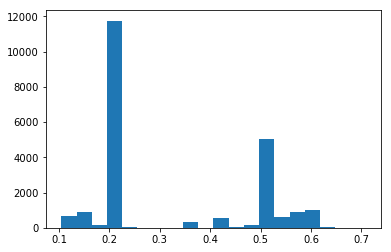

In [14]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [15]:
dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.558
Neg. class accuracy: 0.931
Precision            0.369
Recall               0.558
F1                   0.444
----------------------------------------
TP: 106 | FP: 181 | TN: 2440 | FN: 84



### c) Saving our training labels

Finally, we'll save the `training_marginals`, which are our **"noise-aware training labels"**, so that we can use them in the next tutorial to train our end extraction model:

In [20]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 22254 marginals
CPU times: user 14.1 s, sys: 922 ms, total: 15.1 s
Wall time: 21.4 s


## 4. Structure Learning

We want to include the dependencies between our LFs when training the generative model. Snorkel makes it easy to do this! `DependencySelector` runs a fast structure learning algorithm over the matrix of LF outputs to identify a set of likely dependencies. 

In [17]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.3)
print len(deps)

12


Now we'll train the generative model, using the `deps` argument to account for the learned dependencies. We'll also model LF propensity here, unlike the intro tutorial. In addition to learning the accuracies of the LFs, this also learns their likelihood of labeling an example.

In [19]:
gen_model = GenerativeModel(lf_propensity=True)
%time gen_model.train( L_train, deps=deps, epochs=500, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-4)

Inferred cardinality: 2


KeyboardInterrupt: 

In [ ]:
train_marginals = gen_model.marginals(L_train)

In [ ]:
plt.hist(train_marginals, bins=20)
plt.show()

In [ ]:
dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.score(session, L_dev, L_gold_dev)